In [98]:
import os, pickle

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold, cross_validate, cross_val_score, cross_val_predict, validation_curve
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns


<div style="
    background-color: #439cc8; 
    color: white; 
    font-size: 16px; 
    font-style: italic; 
    padding: 10px 15px; 
    margin-bottom: 15px; 
    border-radius: 8px;">
    <h3>Import des matrice de variable explicative X<br>
    et des vecteur colonne de variable dépendante y</h3>
    <ul>
    <li>train</li>
   <li>test</li>
</div>

In [87]:
X_train = pd.read_feather("data_model/X_train.feather")
y_train = pd.read_feather("data_model/y_train.feather").squeeze()
X_test = pd.read_feather("data_model/X_test.feather")
y_test = pd.read_feather("data_model/y_test.feather").squeeze()

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Type y_train: {type(y_train)}")

X_train: (17247, 36), y_train: (17247,)
X_test: (4312, 36), y_test: (4312,)
Type y_train: <class 'pandas.core.series.Series'>


In [88]:
X_train.head(5)

,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,floor,is_floor_under,rent_price,buy_price_by_area,...,energy_certificate,has_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east,product,neighborhood
0,60,<NA>,0,1,<NA>,<NA>,6,0,1711,8656,...,f,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,estudio,36
1,61,55,3,1,<NA>,<NA>,4,0,646,2049,...,None,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,piso,124
2,148,<NA>,3,3,<NA>,<NA>,3,0,2514,6419,...,None,0,<NA>,<NA>,0,1,0,0,piso,35
3,72,68,2,2,<NA>,<NA>,4,0,1148,3889,...,None,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,piso,22
4,70,62,3,1,<NA>,<NA>,2,0,705,1999,...,g,0,<NA>,<NA>,0,0,1,0,piso,13


In [89]:
print(f"X_train : {X_train.shape}\ny_train : {y_train.shape}")

X_train : (17247, 36)
y_train : (17247,)


In [90]:
X_train.columns

Index(['sq_mt_built', 'sq_mt_useful', 'n_rooms', 'n_bathrooms', 'n_floors',
       'sq_mt_allotment', 'floor', 'is_floor_under', 'rent_price',
       'buy_price_by_area', 'is_renewal_needed', 'is_new_development',
       'built_year', 'has_central_heating', 'has_individual_heating', 'has_ac',
       'has_fitted_wardrobes', 'has_lift', 'is_exterior', 'has_garden',
       'has_pool', 'has_terrace', 'has_balcony', 'has_storage_room',
       'is_accessible', 'has_green_zones', 'energy_certificate', 'has_parking',
       'is_parking_included_in_price', 'parking_price', 'is_orientation_north',
       'is_orientation_west', 'is_orientation_south', 'is_orientation_east',
       'product', 'neighborhood'],
      dtype='object')

In [91]:
# 1. Liste des 10 colonnes choisies pour l'application
useful_features = [
    "sq_mt_built", "n_rooms", "n_bathrooms", "neighborhood",
    "has_lift", "has_parking", "has_pool", "has_garden",
    "has_storage_room", "is_floor_under"
]

# 2. Filtrer X_train et X_test immédiatement après le chargement
# On ne garde que les 10 colonnes utiles
X_train = X_train[useful_features]
X_test = X_test[useful_features]

# 3. VERIFICATION DU PRIX (La cause des 13 euros)
# Affiche la moyenne de y_train pour vérifier l'unité
print(f"Moyenne des prix : {y_train.mean()}") 
# Si la moyenne est proche de 13, c'est que y_train est le 'buy_price_by_area' 
# ou un log. Tu dois alors charger 'buy_price' à la place.

Moyenne des prix : 654524.8398562069


<div style="
    background-color: #439cc8; 
    color: white; 
    font-size: 16px; 
    font-style: italic; 
    padding: 10px 15px; 
    margin-bottom: 15px; 
    border-radius: 8px;">
    <p>Vérifie qu'il ne rest pas de variable 'prix'</p>
</div>

In [92]:
for c in ["target", "price", "prix", "price_log"]:
    assert c not in X_train.columns, f"❌ Colonne cible détectée : {c}"
print("✅ Pas de colonne cible détectée dans les features.")

✅ Pas de colonne cible détectée dans les features.


In [93]:
# categorical_features = ["neighborhood", "product"]

# numerical_features = [
#     col for col in X_train.columns
#     if col not in categorical_features
# ]

# dtype_mapping = {col: "category" for col in categorical_features}
# X_train = X_train.astype(dtype_mapping)
# X_test = X_test.astype(dtype_mapping)

In [94]:
# categorical_features

In [95]:
# numerical_features

In [96]:
# # ✅ 3) Préprocesseur avec imputation :
# # - Numérique : Imputer médiane puis StandardScaler
# # - Catégoriel : Imputer mode puis OneHotEncoder
# num_pipeline = make_pipeline(
#     SimpleImputer(strategy="median"),
#     StandardScaler()
# )
# cat_pipeline = make_pipeline(
#     SimpleImputer(strategy="most_frequent"),
#     OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
# )

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", num_pipeline, numerical_features),
#         ("cat", cat_pipeline, categorical_features),
#     ],
# )

# # ✅ 4) Fit/transform - GARDER les noms originaux ET créer les versions scalées
# X_train_scaled = preprocessor.fit_transform(X_train)
# X_test_scaled  = preprocessor.transform(X_test)

# print("\nDonnées transformées:")
# print(f"X_train_scaled shape: {X_train_scaled.shape}")
# print(f"X_test_scaled shape : {X_test_scaled.shape}")
# print(f"Type: {type(X_train_scaled)}")

# print(f"\nDonnées originales conservées:")
# print(f"X_train shape: {X_train.shape}")
# print(f"X_test shape : {X_test.shape}")


In [99]:
# --- REFACTORISATION DU PREPROCESSOR ---
numeric_features = ["sq_mt_built", "n_rooms", "n_bathrooms"]
categorical_features = ["neighborhood"]
binary_features = ["has_lift", "has_parking", "has_pool", "has_garden", "has_storage_room", "is_floor_under"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features),
        ("bin", SimpleImputer(strategy="most_frequent"), binary_features)
    ]
)

### Modele de base - Dummy Regressor

In [101]:
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train_scaled, y_train)

y_pred = dummy.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Dummy Regressor Performance:\nR²: {r2:.4f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}")

Dummy Regressor Performance:
R²: -0.1300
RMSE: 837553.01
MAE: 448444.42


### Regression Linéaire

In [102]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [103]:
lr.score(X_train_scaled, y_train)

0.850070745339887

In [104]:
lr.score(X_test_scaled, y_test)

0.8517168519344759

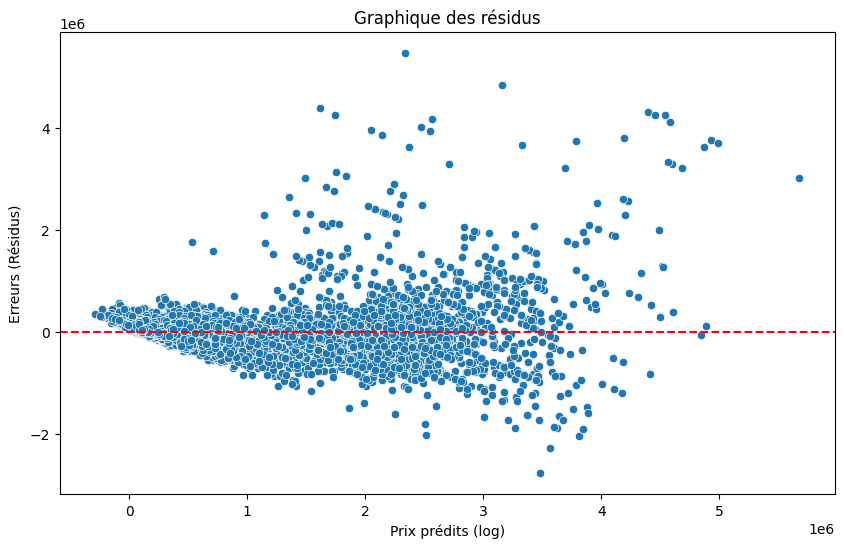

In [105]:
y_train_pred = cross_val_predict(lr, X_train_scaled, y_train, cv=5)

# Prédiction .flatten() force le format 1D
y_train_flat = y_train.values.flatten()

# Calcul les résidus  
residuals = y_train_flat - y_train_pred.flatten()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_pred.ravel(), y=residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Ligne horizontale à 0
plt.title('Graphique des résidus')
plt.xlabel('Prix prédits (log)')
plt.ylabel('Erreurs (Résidus)')
plt.show()

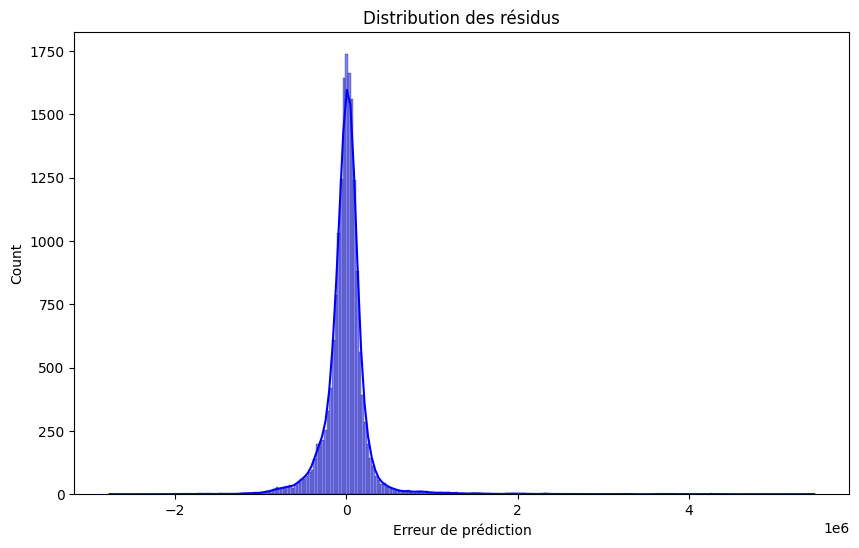

In [106]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution des résidus')
plt.xlabel('Erreur de prédiction')
plt.show()

In [107]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)
rf.score(X_train_scaled, y_train)

0.9987342590876429

Détection d'over fitting avec validation_curve

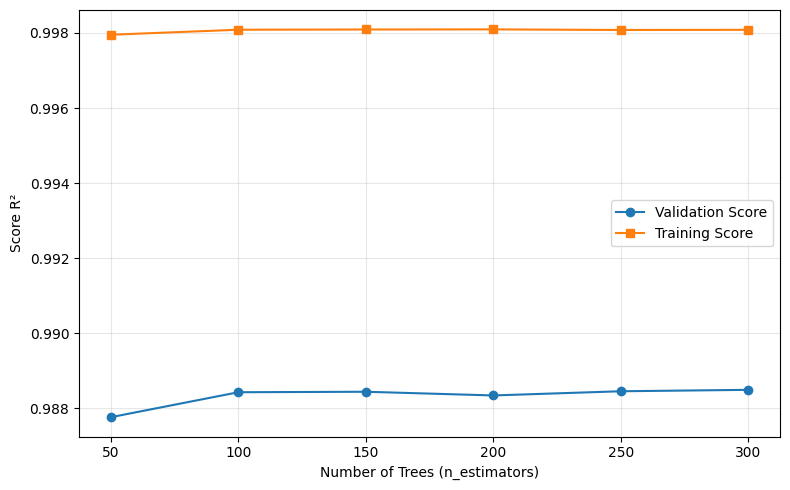

In [108]:
param_range = np.arange(50, 301, 50)

plt.figure(figsize=(8, 5))

train_score, val_score = validation_curve(
    estimator=rf,
    X=X_train_scaled,
    y=y_train,
    param_name="n_estimators",
    param_range=param_range,
    cv=3,
    scoring="r2",
    n_jobs=-1,
)

plt.plot(param_range, val_score.mean(axis=1), marker="o", label="Validation Score")
plt.plot(param_range, train_score.mean(axis=1), marker="s", label="Training Score")
plt.ylabel("Score R²")
plt.xlabel("Number of Trees (n_estimators)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Analyse :
On observe un plateau rapide dès 50-100 arbres.<br>
L'écart constant entre le score d'entraînement (proche de 1.0) et le score de validation indique un modèle complexe qui tend à mémoriser les données (overfitting).<br>
Augmenter le nombre d'arbres au-delà de 100 n'améliore pas la généralisation<br> mais augmente le coût de calcul.

In [112]:
import json
import joblib
from sklearn.model_selection import train_test_split

# ========== REFACTORISATION COMPLÈTE ==========
# 1. Garder uniquement les 10 variables choisies
useful_features = [
    "sq_mt_built", "n_rooms", "n_bathrooms", "neighborhood",
    "has_lift", "has_parking", "has_pool", "has_garden",
    "has_storage_room", "is_floor_under"
]

# 2. Charger les données brutes (pas les scaled)
print("📥 Chargement des données...")
df_train = pd.read_feather("data_model/X_train.feather")
y_train_raw = pd.read_feather("data_model/y_train.feather").squeeze()

df_test = pd.read_feather("data_model/X_test.feather")
y_test_raw = pd.read_feather("data_model/y_test.feather").squeeze()

print(f"df_train: {df_train.shape}, y_train_raw: {y_train_raw.shape}")
print(f"Colonne cible: '{y_train_raw.name}'")

# 3. Sélectionner uniquement les features utiles
X_train = df_train[useful_features].copy()
X_test = df_test[useful_features].copy()

# 4. Entraîner sur le LOG du prix (pour meilleure précision)
y_train = np.log(y_train_raw)
y_test = np.log(y_test_raw)

print(f"\n✅ Données préparées:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"  Features: {useful_features}")

# 5. Créer le préprocesseur uniquement sur les 10 features
numeric_cols = ["sq_mt_built", "n_rooms", "n_bathrooms"]
categorical_cols = ["neighborhood"]
binary_cols = ["has_lift", "has_parking", "has_pool", "has_garden", "has_storage_room", "is_floor_under"]

num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, numeric_cols),
        ("cat", cat_pipeline, categorical_cols),
    ]
)

# 6. Fit et transform
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"✅ Preprocessing OK: {X_train_transformed.shape[1]} features après transformation")

# 7. Entraîner le modèle Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_transformed, y_train)

# 8. Évaluation
r2_train = ridge_model.score(X_train_transformed, y_train)
r2_test = ridge_model.score(X_test_transformed, y_test)
y_pred_test = ridge_model.predict(X_test_transformed)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

print(f"\n📊 Scores du modèle Ridge:")
print(f"  R² Train: {r2_train:.4f}")
print(f"  R² Test:  {r2_test:.4f}")
print(f"  MAE Test: {mae_test:.4f}")
print(f"  RMSE Test: {rmse_test:.4f}")


📥 Chargement des données...
df_train: (17247, 36), y_train_raw: (17247,)
Colonne cible: 'buy_price'

✅ Données préparées:
  X_train: (17247, 10), y_train: (17247,)
  X_test: (4312, 10), y_test: (4312,)
  Features: ['sq_mt_built', 'n_rooms', 'n_bathrooms', 'neighborhood', 'has_lift', 'has_parking', 'has_pool', 'has_garden', 'has_storage_room', 'is_floor_under']
✅ Preprocessing OK: 128 features après transformation

📊 Scores du modèle Ridge:
  R² Train: 0.8780
  R² Test:  0.8797
  MAE Test: 0.2421
  RMSE Test: 0.3184


In [114]:
# ========== SAUVEGARDE & SYNCHRONISATION AVEC L'API ==========

# Créer le dossier models s'il n'existe pas
if not os.path.exists("models"):
    os.makedirs("models")
    print("📁 Dossier models/ créé")

# 1. Sauvegarder le modèle Ridge
joblib.dump(ridge_model, "models/ridge_model.pkl")
print("✅ Modèle Ridge sauvegardé: models/ridge_model.pkl")

# 2. Sauvegarder le préprocesseur
joblib.dump(preprocessor, "models/preprocessor.pkl")
print("✅ Préprocesseur sauvegardé: models/preprocessor.pkl")

# 3. Créer la config JSON pour l'API (10 colonnes seulement)
config = {
    "input_columns": useful_features,
    "model_type": "Ridge",
    "target": y_train_raw.name,
    "use_log": True
}

with open("models/model_config.json", "w") as f:
    json.dump(config, f, indent=2)
print("✅ Config API sauvegardée: models/model_config.json")

# 4. Créer la config Streamlit
streamlit_config = {
    "input_columns": useful_features,
    "numeric_features": numeric_cols,
    "categorical_features": categorical_cols,
    "binary_features": binary_cols,
    "ranges": {
        col: {
            "min": float(X_train[col].min()),
            "max": float(X_train[col].max()),
            "mean": float(X_train[col].mean())
        }
        for col in numeric_cols
    },
    "categorical_values": {
        col: X_train[col].unique().tolist()
        for col in categorical_cols
    }
}

with open("models/streamlit_config.json", "w") as f:
    json.dump(streamlit_config, f, indent=2)
print("✅ Config Streamlit sauvegardée: models/streamlit_config.json")

# 5. Résumé final
print("\n" + "="*60)
print("🎉 NOTEBOOK REFACTORISÉ & SYNCHRONISÉ AVEC L'API")
print("="*60)
print(f"📊 Modèle: Ridge Regression (log du prix)")
print(f"📋 Features: {len(useful_features)} colonnes")
print(f"   {useful_features}")
print(f"📈 Performance:")
print(f"   R² Test: {r2_test:.4f}")
print(f"   MAE Test: {mae_test:.4f}")
print(f"\n✅ Fichiers sauvegardés dans /models/:")
print(f"   - ridge_model.pkl (modèle)")
print(f"   - preprocessor.pkl (pipeline preprocessing)")
print(f"   - model_config.json (config API)")
print(f"   - streamlit_config.json (config Streamlit)")
print("="*60)
print("🚀 Redémarrez Docker: docker-compose restart")
print("="*60)

✅ Modèle Ridge sauvegardé: models/ridge_model.pkl
✅ Préprocesseur sauvegardé: models/preprocessor.pkl
✅ Config API sauvegardée: models/model_config.json
✅ Config Streamlit sauvegardée: models/streamlit_config.json

🎉 NOTEBOOK REFACTORISÉ & SYNCHRONISÉ AVEC L'API
📊 Modèle: Ridge Regression (log du prix)
📋 Features: 10 colonnes
   ['sq_mt_built', 'n_rooms', 'n_bathrooms', 'neighborhood', 'has_lift', 'has_parking', 'has_pool', 'has_garden', 'has_storage_room', 'is_floor_under']
📈 Performance:
   R² Test: 0.8797
   MAE Test: 0.2421

✅ Fichiers sauvegardés dans /models/:
   - ridge_model.pkl (modèle)
   - preprocessor.pkl (pipeline preprocessing)
   - model_config.json (config API)
   - streamlit_config.json (config Streamlit)
🚀 Redémarrez Docker: docker-compose restart


In [115]:
# ========== TEST DES PRÉDICTIONS ==========
print("🧪 Test des prédictions sur le test set:\n")

# Prédictions sur les 5 premiers exemples du test set
y_pred_log = ridge_model.predict(X_test_transformed[:5])
y_actual_log = y_test.iloc[:5].values

print("Index | Y_Actual_LOG | Y_Pred_LOG | Y_Actual_EUR | Y_Pred_EUR | Erreur%")
print("------|--------------|------------|--------------|-----------|---------")
for i in range(5):
    y_actual_eur = np.exp(y_actual_log[i])
    y_pred_eur = np.exp(y_pred_log[i])
    erreur_pct = abs(y_actual_eur - y_pred_eur) / y_actual_eur * 100
    print(f"{i:5d} | {y_actual_log[i]:12.4f} | {y_pred_log[i]:10.4f} | {y_actual_eur:12.0f} | {y_pred_eur:9.0f} | {erreur_pct:7.1f}%")

print(f"\n📊 Range des prédictions LOG en test:")
print(f"   Min: {y_pred_log.min():.4f} → {np.exp(y_pred_log.min()):,.0f} €")
print(f"   Max: {y_pred_log.max():.4f} → {np.exp(y_pred_log.max()):,.0f} €")
print(f"   Mean: {y_pred_log.mean():.4f} → {np.exp(y_pred_log.mean()):,.0f} €")

print(f"\n📊 Range des valeurs RÉELLES LOG en test:")
print(f"   Min: {y_test.min():.4f} → {np.exp(y_test.min()):,.0f} €")
print(f"   Max: {y_test.max():.4f} → {np.exp(y_test.max()):,.0f} €")
print(f"   Mean: {y_test.mean():.4f} → {np.exp(y_test.mean()):,.0f} €")

🧪 Test des prédictions sur le test set:

Index | Y_Actual_LOG | Y_Pred_LOG | Y_Actual_EUR | Y_Pred_EUR | Erreur%
------|--------------|------------|--------------|-----------|---------
    0 |      13.2862 |    13.2739 |       589000 |    581828 |     1.2%
    1 |      12.5245 |    12.4073 |       275000 |    244581 |    11.1%
    2 |      12.6115 |    13.0788 |       300000 |    478705 |    59.6%
    3 |      14.4033 |    14.5548 |      1800000 |   2094487 |    16.4%
    4 |      14.6699 |    14.7353 |      2350000 |   2508793 |     6.8%

📊 Range des prédictions LOG en test:
   Min: 12.4073 → 244,581 €
   Max: 14.7353 → 2,508,793 €
   Mean: 13.6100 → 814,264 €

📊 Range des valeurs RÉELLES LOG en test:
   Min: 10.7996 → 49,000 €
   Max: 15.9788 → 8,700,000 €
   Mean: 12.9380 → 415,799 €


#### Analyse :
**RandomForest** affiche le meilleur score en validation croisée ($R^2 \approx 0.99$)<br>
mais sa performance chute significativement sur le jeu de test ($R^2 \approx 0.89$)<br>
confirmant un manque de robustesse.

À l'inverse, la **Régression Linéaire** et **Ridge** présentent des scores très stables ($R^2 \approx 0.94$ en CV et en Test)<br>
démontrant une excellente capacité à prédire sur des données inconnues.

### Conclusion :
Malgré la puissance théorique du RandomForest, les modèles linéaires (Linear/Ridge) s'avèrent être les plus performants pour ce cas d'usage précis.

##### Points clés retenus :
**Simplicité vs Complexité :** La relation entre les variables semble majoritairement linéaire<br>
rendant les modèles simples plus efficaces et moins sujets au sur-apprentissage.


#### Choix final :
Je préconise l'utilisation du modèle **Ridge**<br>
Il offre un excellent compromis entre précision ($R^2 = 0.947$) et stabilité<br>
tout en étant plus léger et interprétable pour une mise en production.

#### Perspectives :
Pour surpasser le modèle linéaire, une optimisation fine des hyperparamètres de régularisation du RandomForest (max_depth, min_samples_leaf) ou l'utilisation d'un modèle de Gradient Boosting (XGBoost/LGBM) pourrait être envisagée dans une prochaine itération.


In [ ]:
print(X_train.columns.tolist())

['sq_mt_built', 'n_rooms', 'n_bathrooms', 'floor', 'is_floor_under', 'rent_price', 'buy_price_by_area', 'is_renewal_needed', 'is_new_development', 'has_central_heating', 'has_individual_heating', 'has_ac', 'has_fitted_wardrobes', 'has_lift', 'is_exterior', 'has_garden', 'has_pool', 'has_terrace', 'has_balcony', 'has_storage_room', 'is_accessible', 'has_green_zones', 'has_parking', 'product', 'neighborhood']


In [ ]:
# Créer le dossier models s'il n'existe pas
if not os.path.exists("models"):
    os.makedirs("models")

# # ==========  Sauvegarder le modèle RandomForest =======
with open("models/random_forest_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

print("✅ Modèle RandomForest sauvegardé : models/random_forest_model.pkl")




# ========   Extraction du modèle Ridge depuis le dictionnaire models ========
ridge_model = models['Ridge']

# Sauvegarde du modèle Ridge
model_path = "models/ridge_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(ridge_model, f)

print(f"✅ Modèle Ridge sauvegardé : {model_path}")



# ========= Preprocessor complet (Pipeline + ColumnTransformer) =========
# Contient Imputers, StandardScaler et OneHotEncoder
with open("models/preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f) 

print("✅ Pipeline de production sauvegardé :")
print("   - Modèle : models/ridge_model.pkl")
print("   - Préprocesseur : models/preprocessor.pkl")

✅ Modèle RandomForest sauvegardé : models/random_forest_model.pkl
✅ Modèle Ridge sauvegardé : models/ridge_model.pkl
✅ Pipeline de production sauvegardé :
   - Modèle : models/ridge_model.pkl
   - Préprocesseur : models/preprocessor.pkl


In [ ]:
import json

# ========= Extraire les colonnes nécessaires pour la prédiction =========

# 1. Colonnes d'INPUT (ce que l'API recevra)
input_columns = X_train.columns.tolist()
print(f"✅ Colonnes en INPUT: {input_columns}")

# 2. Colonnes APRÈS PREPROCESSING (ce que le modèle ridge attend)
# On utilise le preprocessor pour obtenir les noms après transformation
preprocessor_feature_names = []

# Récupérer les noms des features numériques
for name, transformer, cols in preprocessor.transformers_:
    if name == "num":
        preprocessor_feature_names.extend(cols)
    elif name == "cat":
        # OneHotEncoder crée des noms du type "feature_value"
        # Récupérer le transformeur OneHotEncoder
        onehot = transformer.named_steps['onehotencoder']
        cat_names = onehot.get_feature_names_out(cols)
        preprocessor_feature_names.extend(cat_names)

print(f"✅ Colonnes après PREPROCESSING ({len(preprocessor_feature_names)}): ")
print(preprocessor_feature_names[:10], "...")  # Afficher les 10 premières

# 3. Sauvegarder la configuration dans un JSON
config = {
    "input_columns": input_columns,
    "preprocessed_columns": preprocessor_feature_names,
    "model_type": "Ridge",
    "preprocessing_type": "ColumnTransformer with OneHotEncoder"
}

with open("models/model_config.json", "w") as f:
    json.dump(config, f, indent=2)

print("\n✅ Configuration sauvegardée: models/model_config.json")
print(f"   - Input columns: {len(input_columns)}")
print(f"   - Preprocessed columns: {len(preprocessor_feature_names)}")


✅ Colonnes en INPUT: ['sq_mt_built', 'n_rooms', 'n_bathrooms', 'floor', 'is_floor_under', 'rent_price', 'buy_price_by_area', 'is_renewal_needed', 'is_new_development', 'has_central_heating', 'has_individual_heating', 'has_ac', 'has_fitted_wardrobes', 'has_lift', 'is_exterior', 'has_garden', 'has_pool', 'has_terrace', 'has_balcony', 'has_storage_room', 'is_accessible', 'has_green_zones', 'has_parking', 'product', 'neighborhood']
✅ Colonnes après PREPROCESSING (156): 
['sq_mt_built', 'n_rooms', 'n_bathrooms', 'floor', 'is_floor_under', 'rent_price', 'buy_price_by_area', 'is_renewal_needed', 'is_new_development', 'has_central_heating'] ...

✅ Configuration sauvegardée: models/model_config.json
   - Input columns: 25
   - Preprocessed columns: 156


In [ ]:
# ========= VARIABLES STREAMLIT - Export Minimal =========

import pickle
import json

streamlit_config = {
    # Features
    "input_columns": X_train.columns.tolist(),
    "numerical_features": numerical_features,
    "categorical_features": categorical_features,
    
    # Ranges pour les sliders (optionnel)
    "ranges": {
        col: {
            "min": float(X_train[col].min()),
            "max": float(X_train[col].max()),
            "mean": float(X_train[col].mean())
        } 
        for col in numerical_features
    },
    
    # Categorical values options
    "categorical_values": {
        col: X_train[col].unique().tolist()
        for col in categorical_features
    }
}

# Sauvegarder la configuration
with open("models/streamlit_config.json", "w") as f:
    json.dump(streamlit_config, f, indent=2)

# Sauvegarder les modèles en pickle
with open("models/ridge_model.pkl", "wb") as f:
    pickle.dump(ridge_model, f)

with open("models/preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

print("✅ Configuration Streamlit sauvegardée:")
print(f"   - input_columns: {streamlit_config['input_columns']}")
print(f"   - numerical_features: {streamlit_config['numerical_features']}")
print(f"   - categorical_features: {streamlit_config['categorical_features']}")
print(f"   - Fichiers: models/streamlit_config.json, models/ridge_model.pkl, models/preprocessor.pkl")